### Neural Collaborative Filtering
- https://arxiv.org/pdf/1708.05031v2.pdf


- Official NCF implementation [Keras with Theano]: https://github.com/hexiangnan/neural_collaborative_filtering

In [ ]:
!pip install tf_slim
!pip install gdown
!pip install recommenders

  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633951 sha256=57c39e049be43c1f9ee3675547b349f8a5b414f88734398fea12609dacb1b5dd
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built lightfm memory-profiler retrying scikit-surprise
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from datetime import datetime
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import sparse
from scipy.sparse import csc_matrix
from sklearn.decomposition import TruncatedSVD
import random
random.seed(0)
np.random.seed(0)

In [ ]:

from datetime import datetime, timedelta

from recommenders.datasets.python_splitters import (
    python_chrono_split
   
)

In [ ]:
SEED = 42
np.random.seed(SEED)

## Analyse Dataset

### Food.com   Dataset
- https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions
- https://aclanthology.org/D19-1613/

In [ ]:
!gdown https://drive.google.com/uc?id=1dK__rulbUEGU_m68RIK7Qevc7pcpOIme
!gdown https://drive.google.com/uc?id=1dN-wpxE3V8yNVKPByHReEaswl9UNV9wj

Downloading...
From: https://drive.google.com/uc?id=1dK__rulbUEGU_m68RIK7Qevc7pcpOIme
To: /content/RAW_recipes.csv
100% 295M/295M [00:00<00:00, 325MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dN-wpxE3V8yNVKPByHReEaswl9UNV9wj
To: /content/RAW_interactions.csv
100% 349M/349M [00:02<00:00, 118MB/s]


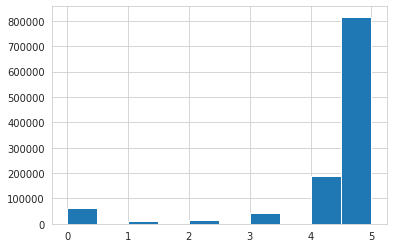

In [ ]:
rating_df =pd.read_csv('RAW_interactions.csv')
rating_df['rating'].hist()

In [ ]:
rating_df=rating_df[['user_id','recipe_id','date','rating']]
rating_df.rename(columns = {'user_id':'userID', 'recipe_id':'itemID'}, inplace = True)

x = rating_df.groupby('itemID').count()['rating'] >= 40
userIndex = x[x].index
nm_rating_df=rating_df[rating_df['itemID'].isin(userIndex)]
y = nm_rating_df.groupby('userID').count()['rating']>=60
items = y[y].index
rating_df = nm_rating_df[nm_rating_df['userID'].isin(items)]
rating_df.shape

(50686, 4)

In [ ]:
unique_users = rating_df.userID.unique()
user_ids = dict(zip(unique_users, np.arange(unique_users.shape[0], dtype=np.int32)))

unique_items = rating_df.itemID.unique()
item_ids = dict(zip(unique_items, np.arange(unique_items.shape[0], dtype=np.int32)))

In [ ]:
product_ids = list(set(list(rating_df.itemID.unique())))
user_ids = list(set(list(rating_df.userID.unique())))

In [ ]:
dict_products = {}
index = 0
for ids in sorted(product_ids):
    dict_products[ids] = index
    index += 1

In [ ]:
dict_users = {}
index = 0
for ids in sorted(user_ids):
    dict_users[ids] = index
    index += 1

### Prepare train test set

In [ ]:
rating_df["itemID"] = rating_df["itemID"].map(dict_products)
rating_df["userID"] = rating_df["userID"].map(dict_users)

In [ ]:
final_ratings=rating_df.sort_values(by=['userID','date','rating'], ascending=[False,False,False]) 
final_ratings.shape

(50686, 4)

In [ ]:
test_df=final_ratings.groupby('userID').head(10)
test_df.shape

(4670, 4)

In [ ]:
final_ratings=final_ratings[~final_ratings.isin(test_df).all(1)]
final_ratings.shape

(46016, 4)

In [ ]:
train_df=final_ratings

In [ ]:
test_df = test_df[test_df["userID"].isin(train_df["userID"].unique())]
test_df = test_df[test_df["itemID"].isin(train_df["itemID"].unique())]

In [ ]:
test_df.head(1)

,userID,itemID,date,rating
739825,466,1210,2018-08-30,4


In [ ]:
train_file = "./train.csv"
test_file = "./test.csv"
train_df.to_csv(train_file, index=False)
test_df.to_csv(test_file, index=False)


### Use NCF using recommenders

In [ ]:
import tensorflow as tf
from recommenders.utils.timer import Timer
from recommenders.models.ncf.ncf_singlenode import NCF
from recommenders.models.ncf.dataset import Dataset as NCFDataset
from recommenders.datasets import movielens
from recommenders.utils.notebook_utils import is_jupyter
from recommenders.datasets.python_splitters import python_chrono_split
from recommenders.evaluation.python_evaluation import (rmse, mae, rsquared, exp_var, map_at_k, ndcg_at_k, precision_at_k, 
                                                     recall_at_k, get_top_k_items)

In [ ]:
data = NCFDataset(train_file=train_file, test_file=test_file, seed=SEED, overwrite_test_file_full=True)

100%|██████████| 467/467 [00:08<00:00, 57.03it/s]


Train NeuMF based on TensorFlow

In [ ]:
EPOCHS=100
BATCH=256
LAYER=[512,256,32]
LR=1e-3
model = NCF (
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=4,
    layer_sizes=LAYER,
    n_epochs=EPOCHS,
    batch_size=BATCH,
    learning_rate=LR,
    verbose=10,
    seed=SEED
)

In [ ]:
with Timer() as timer:
    model.fit(data)

print("Took {} seconds for training.".format(timer.interval))

Took 453.793302853 seconds for training.


In [ ]:
predictions = [[row.userID, row.itemID, model.predict(row.userID, row.itemID)]
               for (_, row) in test_df.iterrows()]


predictions = pd.DataFrame(predictions, columns=['userID', 'itemID', 'prediction'])
predictions.head(5)

,userID,itemID,prediction
0,466,1210,2.173091e-13
1,466,1889,6.299717e-06
2,466,1818,1.852359e-13
3,466,1691,1.388394e-08
4,466,782,2.242040e-12


### Evaluation

In [ ]:
with Timer() as test_time:

    users, items, preds = [], [], []
    item = list(train_df.itemID.unique())
    for user in train_df.userID.unique():
        user = [user] * len(item) 
        users.extend(user)
        items.extend(item)
        preds.extend(list(model.predict(user, item, is_list=True)))

    all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

    merged = pd.merge(train_df, all_predictions, on=["userID", "itemID"], how="outer")
    all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

print("Took {} seconds for prediction.".format(test_time.interval))

Took 2.682636042000013 seconds for prediction.


In [ ]:
TOP_K=20
eval_map = map_at_k(test_df, all_predictions, col_prediction='prediction', k=TOP_K)
eval_precision = precision_at_k(test_df, all_predictions, col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(test_df, all_predictions, col_prediction='prediction', k=TOP_K)

print("MAP:\t%f" % eval_map,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.004698
Precision@K:	0.013490
Recall@K:	0.027005


In [ ]:
k = 20

ndcgs = []
hit_ratio = []

for b in data.test_loader():
    user_input, item_input, labels = b
    output = model.predict(user_input, item_input, is_list=True)

    output = np.squeeze(output)
    rank = sum(output >= output[0])
    if rank <= k:
        ndcgs.append(1 / np.log(rank + 1))
        hit_ratio.append(1)
    else:
        ndcgs.append(0)
        hit_ratio.append(0)

eval_ndcg = np.mean(ndcgs)
eval_hr = np.mean(hit_ratio)

print("Hit Rate:\t%f" % eval_hr)
print("Normalized Discounted Cumulative Gain :\t%f" % eval_ndcg)

Hit Rate:	0.361057
Normalized Discounted Cumulative Gain :	0.203687


### Combine GMF and MLP

In [ ]:
EPOCHS=100
BATCH=256
LAYER=[512,256,32]
LR=1e-3
model = NCF (
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="GMF",
    n_factors=4,
    layer_sizes=LAYER,
    n_epochs=EPOCHS,
    batch_size=BATCH,
    learning_rate=1e-3,
    verbose=10,
    seed=SEED
)

In [ ]:
with Timer() as train_time:
    model.fit(data)

print("Took {} seconds for training.".format(train_time.interval))

model.save(dir_name=".pretrain/GMF")

Took 354.271725616 seconds for training.


In [ ]:

EPOCHS=100
BATCH=256
LAYER=[512,256,32]
LR=1e-3
model = NCF (
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="MLP",
    n_factors=4,
    layer_sizes=LAYER,
    n_epochs=EPOCHS,
    batch_size=BATCH,
    learning_rate=1e-3,
    verbose=10,
    seed=SEED
)

In [ ]:
with Timer() as train_time:
    model.fit(data)

print("Took {} seconds for training.".format(train_time.interval))

model.save(dir_name=".pretrain/MLP")

Took 376.1006151830002 seconds for training.


In [ ]:
EPOCHS=100
BATCH=256
LAYER=[512,256,32]
LR=1e-3
model = NCF (
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=4,
    layer_sizes=LAYER,
    n_epochs=EPOCHS,
    batch_size=BATCH,
    learning_rate=LR,
    verbose=10,
    seed=SEED
)
model.load(gmf_dir=".pretrain/GMF", mlp_dir=".pretrain/MLP", alpha=0.5)

In [ ]:
with Timer() as train_time:
    model.fit(data)

print("Took {} seconds for training.".format(train_time.interval))

Took 451.5382490019997 seconds for training.


In [ ]:
with Timer() as test_time:

    users, items, preds = [], [], []
    item = list(train_df.itemID.unique())
    for user in train_df.userID.unique():
        user = [user] * len(item) 
        users.extend(user)
        items.extend(item)
        preds.extend(list(model.predict(user, item, is_list=True)))

    all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

    merged = pd.merge(train_df, all_predictions, on=["userID", "itemID"], how="outer")
    all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

print("Took {} seconds for prediction.".format(test_time.interval))

Took 2.739675104000071 seconds for prediction.


In [ ]:
TOP_K=20
eval_map = map_at_k(test_df, all_predictions, col_prediction='prediction', k=TOP_K)
eval_precision = precision_at_k(test_df, all_predictions, col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(test_df, all_predictions, col_prediction='prediction', k=TOP_K)

print("MAP:\t%f" % eval_map,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.003138
Precision@K:	0.005683
Recall@K:	0.014408


In [ ]:
k = 20

ndcgs = []
hit_ratio = []

for b in data.test_loader():
    user_input, item_input, labels = b
    output = model.predict(user_input, item_input, is_list=True)

    output = np.squeeze(output)
    rank = sum(output >= output[0])
    if rank <= k:
        ndcgs.append(1 / np.log(rank + 1))
        hit_ratio.append(1)
    else:
        ndcgs.append(0)
        hit_ratio.append(0)

eval_ndcg = np.mean(ndcgs)
eval_hr = np.mean(hit_ratio)

print("Hit Rate:\t%f" % eval_hr)
print("Normalized Discounted Cumulative Gain :\t%f" % eval_ndcg)

Hit Rate:	0.366430
Normalized Discounted Cumulative Gain :	0.207080
